# Cumulated Graph of the Distance traveled:

This script provides the figure for cumulated water point. (note that you need to build the event "Water Stop" to get this graph)

*Warning: we set the waterpoint at the bottom right of the cage. If you use another location, change the code of the rebuildWaterPoint.py file.*

| ![](../images/cumulatedwaterpoint1.jpg) ![](../images/cumulatedwaterpoint2.jpg) ![](../images/cumulatedwaterpoint3.jpg) ![](../images/cumulatedwaterpoint4.jpg)
|:--:| 
|Example of cumulated water point|

Code launched.


Start :  11111


Entry (in frame) : 11111


End :  99999


Entry (in frame) : 99999
['totalDistance']


Which behavior do you want to plot the Cumulated graph? (No choice here... totalDistance) :  totalDistance


E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221020_Amphet_Cage2_4-1Amphet.sqlite
expName is:  _Amphet_Cage2_4-1Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849390 Genotype:Amphet User1:None
Animal Id:2 Name:B RFID:000004849540 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849551 Genotype:NaCl User1:None
000004849390
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 11111 / 99999 ) Loaded ( 0  records loaded in  2.049017906188965 S )
000004849540
totalDistance  Id( 2 , None , None , None ) Min/maxFrame: ( 11111 / 99999 ) Loaded ( 0  records loaded in  0.11302828788757324 S )
000004849551
totalDistance  Id( 3 , None , None , None ) Min/maxFrame: ( 11111 / 99999 ) Loaded ( 0  records loaded in  0.1090250015258789 S )
Computing the distance:
Animal Id:3 Name:C RFID:000004849551 Genotype:NaCl User1:None : Loading de

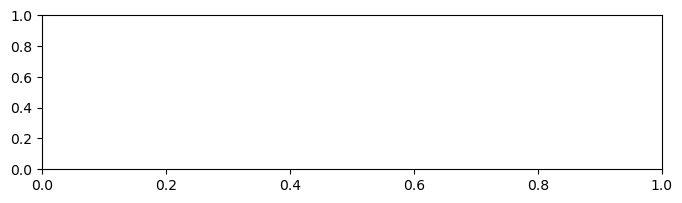

In [2]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *

import lmtanalysis
from tkinter.filedialog import askopenfilename
from tabulate import tabulate
from collections import Counter
import collections
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from lmtanalysis.FileUtil import getFilesToProcess
from lmtanalysis.Util import convert_to_d_h_m_s, getMinTMaxTInput,getFrameInput


def frameToTimeTicker(x, pos):
   
    vals= convert_to_d_h_m_s( x )
    return "D{0} - {1:02d}:{2:02d}".format( int(vals[0])+1, int(vals[1]), int(vals[2]) )
    
if __name__ == '__main__':
    
    print("Code launched.")
    #Choose the files to process
    files = getFilesToProcess()
    tmin = getFrameInput("Start")
    tmax = getFrameInput("End")

    """
    behavioralEvents = ["Contact", "Oral-oral Contact", "Oral-genital Contact", "Side by side Contact", 
                        "Side by side Contact, opposite way", "Social approach", "Get away", "Approach contact", 
                        "Approach rear", "Break contact", "FollowZone Isolated", "Train2", "Group2", "Group3", "Group4",
                        "Group 3 break", "Group 3 make", "Group 4 break", "Group 4 make", "Move isolated", 
                        "Move in contact", "Rear isolated", "Rear in contact", "Stop isolated", 
                        "WallJump","totalDistance", "Fight", "Won Fight", "Lost Fight", "SAP"]
    """
    behavioralEvents = ["totalDistance"]
    
    print(behavioralEvents)
    
    behaviorToPlot = input("Which behavior do you want to plot the Cumulated graph? (No choice here... totalDistance) : ")
    
    saveFile = f"figTimeLine-{behaviorToPlot}"

    for file in files:
        print(file)
        expName = file[-30:-7] #Select the name of XP in the filename
        print("expName is: ", expName )
        
        connection = sqlite3.connect( file )
    
        pool = AnimalPool( )
        pool.loadAnimals( connection )
        """        
        pool.loadDetection( start = tmin, end = tmax, lightLoad=True)
        """
        
        #Load the timeline of the event over all individuals
        behaviorTimeLine = {}
        for animal in pool.animalDictionnary.keys():
            print ( pool.animalDictionnary[animal].RFID )
            behaviorTimeLine[animal] = EventTimeLine( connection, behaviorToPlot, idA=animal, minFrame=tmin, maxFrame=tmax )
#             behaviorTimeLine[animal].removeEventsBelowLength( maxLen = MIN_WATER_STOP_DURATION )

        # Compute the total distance traveled
        COMPUTE_TOTAL_DISTANCE = True
        if ( COMPUTE_TOTAL_DISTANCE == True ):
            print("Computing the distance:")
            pool.animalDictionnary[animal].loadDetection( start=tmin, end=tmax, lightLoad = True )
            animalTotalDistance = pool.animalDictionnary[animal].getDistance( tmin,tmax)/100
            tenMinBin = 10*30*60 #Bins of 10 minutes
            animalBinDistance = pool.animalDictionnary[animal].getDistancePerBin(binFrameSize = tenMinBin , minFrame=tmin, maxFrame=tmax )
        else:
            print("Not computing the distance")
        
        
        #Compute cumulative time spent at water point
        fig, ax = plt.subplots( 1,1 , figsize=(8, 2 ) )
        
        ''' build the plot '''
        ymin=-30
        fig, ax = plt.subplots(1,1 , figsize=(8, 2 ) )
        ax = plt.gca() # get current axis
        ax.set_xlabel("time")
        ax.set_xlim([0, tmax])
        #ax.set_ylim([ymin, ymax])
        
        #set x axis
        formatter = matplotlib.ticker.FuncFormatter( frameToTimeTicker )
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(labelsize=6 )
        ax.xaxis.set_major_locator(ticker.MultipleLocator( 30 * 60 * 60 * 12 ))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator( 30 * 60 * 60 ))
                
        #draw the rectangles for the nights
        print("loading night events for file " + file)
        nightTimeLine = EventTimeLine( connection, "night" , minFrame=tmin, maxFrame=tmax )
        
        for nightEvent in nightTimeLine.getEventList():
            ax.axvspan( nightEvent.startFrame, nightEvent.endFrame, alpha=0.1, color='black')
            ax.text( nightEvent.startFrame+(nightEvent.endFrame-nightEvent.startFrame)/2 , 200 , "dark phase" ,fontsize=6, ha='center')
        
        behaviorDuration = {}
        timeBin = 1
        
        #Print the name and genotype of the animals on the graph, with the corresponding colors and the total distance traveled over the experiment
        legendHeight = 60
        rfids_legend = []
        geno_legend = []
        
        for animal in pool.animalDictionnary.keys():
            rfids_legend.append(pool.animalDictionnary[animal].RFID[:-4])
            geno_legend.append(pool.animalDictionnary[animal].genotype)
            if "Amphet" in pool.animalDictionnary[animal].genotype:
                color = "red"
            else:
                color="blue"
            print ( pool.animalDictionnary[animal].RFID )
            ax.text(30*60*60, legendHeight, "{} {}".format(pool.animalDictionnary[animal].RFID[5:], 
                                                           pool.animalDictionnary[animal].genotype), color = color, fontsize=5)
            
#                     color=getAnimalColor(animal), fontsize=5 )
            legendHeight += 30 
             
        for animal in pool.animalDictionnary.keys():
            listCumulated = []
            listValue = behaviorTimeLine[animal].getDurationEventInTimeBin( tmin=tmin, tmax=tmax, binSize=timeBin*oneMinute)
            cumul = 0
            for value in listValue:
                cumul+= value
                listCumulated.append( cumul )
            behaviorDuration[animal ]= listCumulated
        
        nTimeBins = len(behaviorDuration[1])
        print(nTimeBins)
        
        abs = [1*oneMinute]
        for t in range(1, nTimeBins):
            x = abs[t-1] + timeBin*oneMinute
            abs.append(x)
            
        for animal in behaviorDuration:
            if "Amphet" in pool.animalDictionnary[animal].genotype:
                color = "red"
            else:
                color="blue"
            ax.plot( abs, behaviorDuration[animal] , color= color) # color= getAnimalColor( animal )
                
        ax.legend(geno_legend) #ADD THE GENOTYPE AS LEGEND
        fig.suptitle(f"{expName} / {behaviorToPlot}")

        figName = f"FigCumul-{behaviorToPlot}_{expName}.png"
        print (behaviorToPlot)
        print(expName)
        print ("Saving figure..." , figName )
        fig.savefig( figName ,dpi=100)
        
#         plt.show()
        plt.close( fig )
        connection.close() #Stop connection to the DBs
        print( "*** ALL JOBS DONE *** ")


In [10]:
geno_legend

['OBS', 'SFC+']